In [7]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 13})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 13}
plt.rcParams['text.usetex'] = True
plt.rc('font', **font)

### calculate each ensemble member ts

- first make nice daily files in extractAndProcessCode/04_get_nice_daily_files_for_each_reanalysis.ipynb
    -this includes concatenation step
- then make a ts for each EM in extract_ts_3M.py

### make ensemble averages

In [9]:
ex = True 

def make_ensemble_avg(e1,e2,e3, tlat = '40-60'):
    print(f'EM {e1}')
    tdir = '/gpfs/data/greenocean2/software/products/windsFromComponents/dailyStandard/intProc/'
    e1d = xr.open_dataset(f'{tdir}/scen{e1}_UKESM_{tlat}S_mean_wspd_ts_1950-2099.nc')
    e2d = xr.open_dataset(f'{tdir}/scen{e2}_UKESM_{tlat}S_mean_wspd_ts_1950-2099.nc')
    e3d = xr.open_dataset(f'{tdir}/scen{e3}_UKESM_{tlat}S_mean_wspd_ts_1950-2099.nc')

    # Compute the average of the 'wspd10m' variable across the datasets
    wspd10m_avg = (e1d['wspd10m'] + e2d['wspd10m'] + e3d['wspd10m']) / 3

    # Create a new dataset with the averaged variable
    d4 = xr.Dataset({'wspd10m': wspd10m_avg})

    # Optionally, copy attributes from one of the datasets to the new one
    d4['wspd10m'].attrs = e1d['wspd10m'].attrs
    d4.attrs = {"made in": 'windEval/plottingCode/Fig-attribution3M.ipynb'}
    
    d4.to_netcdf(f'{tdir}/scen{e1}EM_UKESM_{tlat}S_mean_wspd_ts_1950-2099.nc')
    
    return d4

if ex:
    d4 = make_ensemble_avg('1A','1AM2','1AM3')
    d4 = make_ensemble_avg('1B','1BM2','1BM3')
    d4 = make_ensemble_avg('2A','2AM2','2AM3')
    d4 = make_ensemble_avg('2B','2BM2','2BM3')
# # Save or further process the new dataset
# print(d4)



EM 1A


FileNotFoundError: [Errno 2] No such file or directory: b'/gpfs/data/greenocean2/software/products/windsFromComponents/dailyStandard/intProc/scen1AM3_UKESM_40-60S_mean_wspd_ts_1950-2099.nc'

In [11]:
tdir = '/gpfs/data/greenocean2/software/products/windsFromComponents/dailyStandard/intProc/'
w = xr.open_dataset(f'{tdir}scen1AM2_2d-seas-wspd-ts-1980-2019.nc')

w

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, year: 40)
Coordinates:
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * year     (year) int64 1980 1981 1982 1983 1984 ... 2015 2016 2017 2018 2019
Data variables:
    DJF      (year, lat, lon) float32 ...
    MAM      (year, lat, lon) float32 ...
    JJA      (year, lat, lon) float32 ...
    SON      (year, lat, lon) float32 ...
    FY       (year, lat, lon) float32 ...

In [ ]:
import numpy as np


import pymannkendall as mk
from scipy import stats

def give_trends(ts_y):

    ts_x = np.arange(0,len(ts_y))
    trend, h, mk_p, z, Tau, s, var_s, mk_slope, intercept = mk.original_test(ts_y)
    lin_slope, intercept, r_value, lin_p, std_err = stats.linregress(ts_x,ts_y)
    
    return mk_slope, mk_p, lin_slope, lin_p

## dictionary for colours and names

In [2]:
m3dict = {
    '1A': {'name': '','color':'darkgray','linestyle' : '-','linewidth' : 1,},
    '1AM2': {'name': '','color':'darkgray','linestyle' : ':','linewidth' : 1,},
    '1AM3': {'name': '','color':'darkgray','linestyle' : '--','linewidth' : 1,},
    '1AEM': {'name': 'SSP 1-2.6 \n OZONE-HIST.','color':'darkgray','linestyle' : '-','linewidth' : 2.5,},

    '1B': {'name': '','color':'black','linestyle' : '-','linewidth' : 1,},
    '1BM2': {'name': '','color':'black','linestyle' : ':','linewidth' : 1,},
    '1BM3': {'name': '','color':'black','linestyle' : '--','linewidth' : 1,},
    '1BEM': {'name': 'SSP 3-7.0 \n OZOZE-HIST.','color':'black','linestyle' : '-','linewidth' : 2.5,},
    
    '2A': {'name': '','color':'mediumaquamarine','linestyle' : '-','linewidth' : 1,},
    '2AM2': {'name': '','color':'mediumaquamarine','linestyle' : ':','linewidth' : 1,},
    '2AM3': {'name': '','color':'mediumaquamarine','linestyle' : '--','linewidth' : 1,},
    '2AEM': {'name': 'SSP 1-2.6 \n OZONE-1950','color':'mediumaquamarine','linestyle' : '-','linewidth' : 2.5,},

    '2B': {'name': '','color':'forestgreen','linestyle' : '-','linewidth' : 1,},
    '2BM2': {'name': '','color':'forestgreen','linestyle' : ':','linewidth' : 1,},
    '2BM3': {'name': '','color':'forestgreen','linestyle' : '--','linewidth' : 1,},
    '2BEM': {'name': 'SSP 3-7.0 \n OZONE-1950','color':'forestgreen','linestyle' : '-','linewidth' : 2.5,},    
}



## timeseries of 1950-2100 winds for bands 40-60 and 30-70 as well as code to extract them

ts extractor code is made in windEval/plottingCode/extract_ts_3M.py

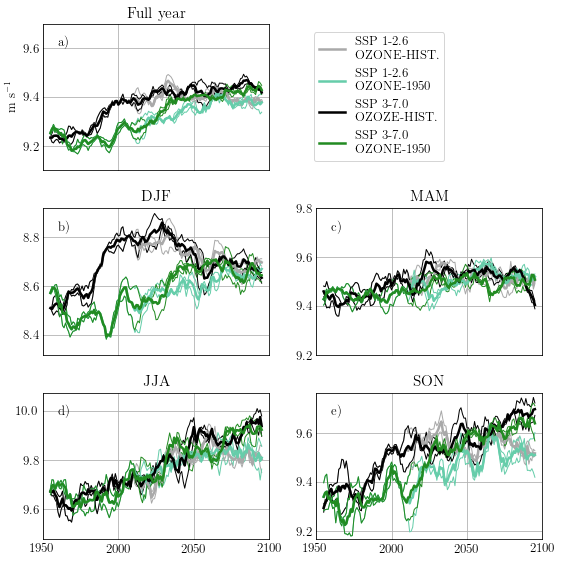

In [3]:

scens = ['1A','1B','2A','2B','1AM2','1BM2','2AM2','2BM2','1AEM','2AEM','1BEM','2BEM']
stl = ['1AEM','2AEM','1BEM','2BEM']
latdegs = ['40-60S']#,'30-70S']

for latdeg in latdegs:

    fact = 1
    fig, axs = plt.subplots(3,2, figsize=(8*fact, 8*fact), sharex=False, sharey=False)
    axs = axs.ravel()


    ts = ['DJF','MAM','JJA','SON']

    for s in scens:
        tdir = '/gpfs/data/greenocean2/software/products/windsFromComponents/dailyStandard/intProc/'
        td = xr.open_dataset(f'{tdir}/scen{s}_UKESM_{latdeg}_mean_wspd_ts_1950-2099.nc')
        g = td.groupby('time_counter.year').mean()

        tv_rol = g.rolling(year=10, center=True).mean()

        #axs[0].plot(g.year,g.wspd10m, color = m3dict[s]['color'], linewidth = m3dict[s]['linewidth'],)
        if s in stl:
            axs[0].plot(tv_rol.year,tv_rol.wspd10m, color = m3dict[s]['color'],\
                        linewidth = m3dict[s]['linewidth'], label = m3dict[s]['name'])    
        else:
            axs[0].plot(tv_rol.year,tv_rol.wspd10m, color = m3dict[s]['color'],\
                        linewidth = m3dict[s]['linewidth'],)



        for i in range(0,4):
            g = td.sel(time_counter=(td['time_counter.season'] == ts[i])).groupby('time_counter.year').mean()
            tv_rol = g.rolling(year=10, center=True).mean()
            axs[i+2].plot(tv_rol.year,tv_rol.wspd10m, color = m3dict[s]['color'], linewidth = m3dict[s]['linewidth'],)

        axs[1].axis('off')

    tmin = [9.1,8.32,9.2,9.475,9.165]
    if latdeg == '30-70S':
        tmin = [8.2,7.35,8.35,8.8,8.25]
    lab = ['a)','b)','c)','d)','e)','b)'] 
    tits = ['Full year','DJF','MAM','JJA','SON']
    ofs = 0.6
    ind = 0
    for i in range(0,6):

        if i != 1:
            axs[i].set_xlim([1950,2100])
            axs[i].set_xticks(np.arange(1950,2150,50))
            axs[i].set_xticklabels([])
            axs[i].set_ylim([tmin[ind],tmin[ind]+ofs])
            axs[i].text(1960,tmin[ind]+0.85*ofs,lab[ind])
            axs[i].tick_params(axis='x', length=0.5)
            axs[i].tick_params(axis='y', length=0.5)
            axs[i].grid()

            axs[i].set_title(tits[ind])
            ind = ind+1

    axs[0].set_ylabel('m s$^{-1}$')
    axs[4].set_xticklabels(np.arange(1950,2150,50))
    axs[5].set_xticklabels(np.arange(1950,2150,50))

    handles, labels = axs[0].get_legend_handles_labels()  # Collect handles and labels from a subplot


    fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.67, 0.82))
    #fig.suptitle(f'UKESM 10m winds {latdeg}')
    plt.tight_layout()

    fig.savefig(f'./plts/ts_{latdeg}_3M_1950-2100-full.jpg', dpi = 300)


## decompose into warming signal and ozone change signal

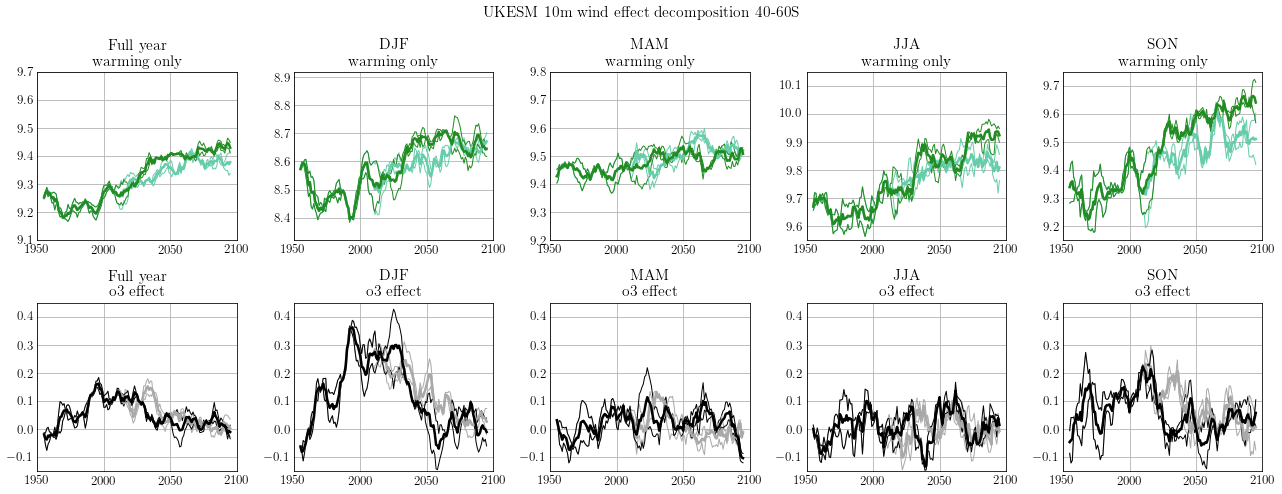

In [4]:
latdegs = ['40-60S']#,'30-70S']

for latdeg in latdegs:


    fact = 1
    fig, axs = plt.subplots(2,5, figsize=(18*fact, 7*fact), sharex=False, sharey=False)
    axs = axs.ravel()

    scens = ['2A','2B','2AM2','2BM2','2AEM','2BEM']
    scens1 = ['1A','1B','1AM2','1BM2','1AEM','1BEM']
    stl = ['1AEM','2AEM','1BEM','2BEM']

    ts = ['DJF','MAM','JJA','SON']

    for s in scens:
        tdir = '/gpfs/data/greenocean2/software/products/windsFromComponents/dailyStandard/intProc/'
        td = xr.open_dataset(f'{tdir}/scen{s}_UKESM_{latdeg}_mean_wspd_ts_1950-2099.nc')
        g = td.groupby('time_counter.year').mean()
        g2 = np.nanmean(td.wspd10m[0:10]) #first 10 yrs
        tv_rol = g.rolling(year=10, center=True).mean()

        #axs[0].plot(g.year,g.wspd10m, color = m3dict[s]['color'], linewidth = m3dict[s]['linewidth'],)
        if s in stl:
            axs[0].plot(tv_rol.year,tv_rol.wspd10m, color = m3dict[s]['color'],\
                        linewidth = m3dict[s]['linewidth'], label = m3dict[s]['name'])    
        else:
            axs[0].plot(tv_rol.year,tv_rol.wspd10m, color = m3dict[s]['color'],\
                        linewidth = m3dict[s]['linewidth'],)
        for i in range(0,4):
            g = td.sel(time_counter=(td['time_counter.season'] == ts[i])).groupby('time_counter.year').mean()
            g2 = np.nanmean(td.wspd10m[0:10])
            tv_rol = g.rolling(year=10, center=True).mean()
            axs[i+1].plot(tv_rol.year,tv_rol.wspd10m, color = m3dict[s]['color'], linewidth = m3dict[s]['linewidth'],)

    tmin = [9.1,8.32,9.2,9.55,9.15]
    if latdeg == '30-70S':
        tmin = [8.2,7.35,8.35,8.8,8.25]
    tits = ['Full year \n warming only','DJF\n warming only','MAM\n warming only','JJA\n warming only','SON\n warming only'] 
    ofs = 0.6
    for i in range(0,5):

        axs[i].set_xlim([1950,2100])
        axs[i].set_xticks(np.arange(1950,2150,50))
        # axs[i].set_xticklabels([])
        axs[i].set_ylim([tmin[i],tmin[i]+ofs])
        axs[i].tick_params(axis='x', length=0.5)
        axs[i].tick_params(axis='y', length=0.5)
        axs[i].grid()

        axs[i].set_title(tits[i])


    ##### ozone component

    for s in range(0,6):
        tdir = '/gpfs/data/greenocean2/software/products/windsFromComponents/dailyStandard/intProc/'
        td2 = xr.open_dataset(f'{tdir}/scen{scens[s]}_UKESM_{latdeg}_mean_wspd_ts_1950-2099.nc')
        td1 = xr.open_dataset(f'{tdir}/scen{scens1[s]}_UKESM_{latdeg}_mean_wspd_ts_1950-2099.nc')
        td = td1 - td2

        g = td.groupby('time_counter.year').mean()
        g2 = np.nanmean(td.wspd10m[0:10]) #first 10 yrs
        tv_rol = g.rolling(year=10, center=True).mean()

        #g1 = td.groupby('time_counter.year').mean()

        tv_rol = g.rolling(year=10, center=True).mean()

        #axs[0].plot(g.year,g.wspd10m, color = m3dict[s]['color'], linewidth = m3dict[s]['linewidth'],)
        if s in stl:
            axs[0+5].plot(tv_rol.year,tv_rol.wspd10m, color = m3dict[scens1[s]]['color'],\
                        linewidth = m3dict[scens1[s]]['linewidth'], label = m3dict[scens1[i]]['name'])    
        else:
            axs[0+5].plot(tv_rol.year,tv_rol.wspd10m, color = m3dict[scens1[s]]['color'],\
                        linewidth = m3dict[scens1[s]]['linewidth'],)
        for i in range(0,4):
            g = td.sel(time_counter=(td['time_counter.season'] == ts[i])).groupby('time_counter.year').mean()
            g2 = np.nanmean(td.wspd10m[0:10])
            tv_rol = g.rolling(year=10, center=True).mean()
            axs[i+6].plot(tv_rol.year,tv_rol.wspd10m, color = m3dict[scens1[s]]['color'], linewidth = m3dict[scens1[s]]['linewidth'],)

    tmin = [-0.15,-0.15,-0.15,-0.15,-0.15,]
    if latdeg == '30-70S':
        tmin = [-0.15,-0.15,-0.15,-0.15,-0.15,]
    tits = ['Full year \n o3 effect','DJF\n o3 effect','MAM\n o3 effect','JJA\n o3 effect','SON\n o3 effect']    
    ofs = 0.6
    for i in range(0,5):

        axs[i+5].set_xlim([1950,2100])
        axs[i+5].set_xticks(np.arange(1950,2150,50))
        # axs[i].set_xticklabels([])
        axs[i+5].set_ylim([tmin[i],tmin[i]+ofs])
        axs[i+5].tick_params(axis='x', length=0.5)
        axs[i+5].tick_params(axis='y', length=0.5)
        axs[i+5].grid()
        axs[i+5].set_title(tits[i])

        fig.suptitle(f'UKESM 10m wind effect decomposition {latdeg}')
        plt.tight_layout()

        fig.savefig(f'./plts/decomposition_{latdeg}_3M_1950-2100-full.png')

## trends and significances of ensemble mean only, 40-60 

2AEM O3AEM, 1AEM, 2BEM, O3BEM, 1BEM

In [5]:
import pymannkendall as mk
from scipy import stats

def give_trends(ts_y):

    ts_x = np.arange(0,len(ts_y))
    trend, h, mk_p, z, Tau, s, var_s, mk_slope, intercept = mk.original_test(ts_y)
    lin_slope, intercept, r_value, lin_p, std_err = stats.linregress(ts_x,ts_y)
    
    return mk_slope, mk_p, lin_slope, lin_p

In [6]:
latdeg = '40-60S'

d2A = xr.open_dataset(f'{tdir}/scen2AEM_UKESM_{latdeg}_mean_wspd_ts_1950-2099.nc')
d1A = xr.open_dataset(f'{tdir}/scen1AEM_UKESM_{latdeg}_mean_wspd_ts_1950-2099.nc')
d2B = xr.open_dataset(f'{tdir}/scen2BEM_UKESM_{latdeg}_mean_wspd_ts_1950-2099.nc')
d1B = xr.open_dataset(f'{tdir}/scen1BEM_UKESM_{latdeg}_mean_wspd_ts_1950-2099.nc')
dO3A = d1A-d2A
dO3B = d1B-d2B



In [7]:
def get_trend_sig(ts,y1,y2,seas):
    
    if seas == 'FY':
        g = ts.wspd10m.groupby('time_counter.year').mean().sel(year=slice(y1,y2)).values
        mk_slope, mk_p, lin_slope, lin_p = give_trends(g)
        lin_slope = lin_slope*10
    else:
        g = ts.wspd10m.sel(time_counter=(td['time_counter.season'] == seas)).\
        groupby('time_counter.year').mean().sel(year=slice(y1,y2)).values         
        mk_slope, mk_p, lin_slope, lin_p = give_trends(g)
        lin_slope = lin_slope*10
        
    return lin_slope, lin_p

lin_slope, lin_p = get_trend_sig(d1A,1950,1999,'DJF')
print(f'{lin_slope}, {lin_p}')

0.062488599821761, 5.436388045950804e-09


In [8]:
y1 = 1950; y2 = 1999; latdeg = '40-60S'

def get_ukesm3m(y1,y2, latdeg = '40-60S'):
    print(f'{y1}-{y2}')

    data = np.zeros([5,6])
    data2 = np.zeros([5,6])

    tdir = '/gpfs/data/greenocean2/software/products/windsFromComponents/dailyStandard/intProc/'

    d2A = xr.open_dataset(f'{tdir}/scen2AEM_UKESM_{latdeg}_mean_wspd_ts_1950-2099.nc')
    d1A = xr.open_dataset(f'{tdir}/scen1AEM_UKESM_{latdeg}_mean_wspd_ts_1950-2099.nc')
    d2B = xr.open_dataset(f'{tdir}/scen2BEM_UKESM_{latdeg}_mean_wspd_ts_1950-2099.nc')
    d1B = xr.open_dataset(f'{tdir}/scen1BEM_UKESM_{latdeg}_mean_wspd_ts_1950-2099.nc')
    dO3A = d1A-d2A
    dO3B = d1B-d2B


    ems = [d2A,dO3A,d1A,d2B,dO3B,d1B,]
    emn = ['d2A','dO3A','d1A','d2B','dO3B','d1B',]

    df = pd.DataFrame(data, columns=emn,\
                      index  = ['FY','DJF','MAM', 'JJA', 'SON',])
    df2 = pd.DataFrame(data2, columns=emn,\
                      index  = ['FY','DJF','MAM', 'JJA', 'SON',])

    seas = ['FY','DJF','MAM', 'JJA', 'SON',]
    for e in range(0,6):
        for s in seas:
            ts = ems[e]
            tn = emn[e]
            lin_slope, lin_p = get_trend_sig(ts,y1,y2,s)
            df.loc[s, tn] = lin_slope
            if lin_p < 0.05:
                df2.loc[s, tn] = lin_slope


    df.attrs = {"made in": 'plottingCode/Fig-attribution3M.ipynb'}
    df.to_csv(f'./plts/attr-UKESM3M_{latdeg}-trend-{y1}-{y2}.csv')
    df2.attrs = {"made in": 'plottingCode/Fig-attribution3M.ipynb'}
    df2.to_csv(f'./plts/attr-UKESM3M_{latdeg}-trendsig-{y1}-{y2}.csv')
    print('saved')



In [9]:
y1 = 1950; y2 = 1999; latdeg = '40-60S'

ex = False
if ex:
    get_ukesm3m(1950,1999)
    get_ukesm3m(2000,2049)
    get_ukesm3m(2050,2099)

ex = True
if ex:
    get_ukesm3m(1980,1999)
    get_ukesm3m(1980,2019)
    #get_ukesm3m(2050,2099)

1980-1999
saved
1980-2019
saved


## trends

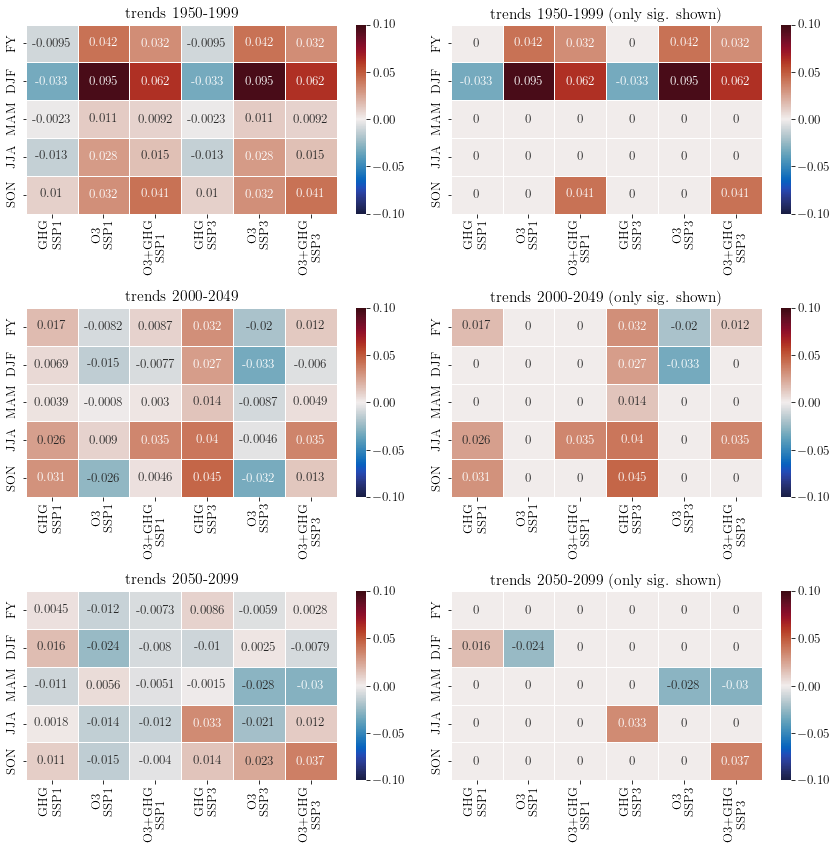

In [10]:

import seaborn as sns
fact = 1
fig, axs = plt.subplots(3,2, figsize=(12*fact, 12*fact), sharex=False, sharey=False)
axs = axs.ravel()

tid = 'trend'
vmin = -0.1; vmax = 0.1; tcmap = cm.balance

y1 = 1950; y2 = 1999; latdeg = '40-60S'; ind = 0
df = pd.read_csv(f'./plts/attr-UKESM3M_{latdeg}-trend-{y1}-{y2}.csv', index_col=0)
df = df.rename(columns={"d2A": "GHG\n SSP1", "dO3A": "O3 \n SSP1", "d1A": "O3+GHG \n SSP1",\
                       "d2B": "GHG\n SSP3", "dO3B": "O3 \n SSP3", "d1B": "O3+GHG \n SSP3"})

sns.heatmap(df, cmap=tcmap, linewidths=0.5, annot=True, vmin = vmin, vmax = vmax, ax = axs[ind])
axs[ind].set_title(f'trends {y1}-{y2}')

df = pd.read_csv(f'./plts/attr-UKESM3M_{latdeg}-trendsig-{y1}-{y2}.csv', index_col=0)
df = df.rename(columns={"d2A": "GHG\n SSP1", "dO3A": "O3 \n SSP1", "d1A": "O3+GHG \n SSP1",\
                       "d2B": "GHG\n SSP3", "dO3B": "O3 \n SSP3", "d1B": "O3+GHG \n SSP3"})

sns.heatmap(df, cmap=tcmap, linewidths=0.5, annot=True, vmin = vmin, vmax = vmax, ax = axs[ind+1])
axs[ind+1].set_title(f'trends {y1}-{y2} (only sig. shown)')

y1 = 2000; y2 = 2049; latdeg = '40-60S'; ind = 2
df = pd.read_csv(f'./plts/attr-UKESM3M_{latdeg}-trend-{y1}-{y2}.csv', index_col=0)
df = df.rename(columns={"d2A": "GHG\n SSP1", "dO3A": "O3 \n SSP1", "d1A": "O3+GHG \n SSP1",\
                       "d2B": "GHG\n SSP3", "dO3B": "O3 \n SSP3", "d1B": "O3+GHG \n SSP3"})

sns.heatmap(df, cmap=tcmap, linewidths=0.5, annot=True, vmin = vmin, vmax = vmax, ax = axs[ind])
axs[ind].set_title(f'trends {y1}-{y2}')

df = pd.read_csv(f'./plts/attr-UKESM3M_{latdeg}-trendsig-{y1}-{y2}.csv', index_col=0)
df = df.rename(columns={"d2A": "GHG\n SSP1", "dO3A": "O3 \n SSP1", "d1A": "O3+GHG \n SSP1",\
                       "d2B": "GHG\n SSP3", "dO3B": "O3 \n SSP3", "d1B": "O3+GHG \n SSP3"})

sns.heatmap(df, cmap=tcmap, linewidths=0.5, annot=True, vmin = vmin, vmax = vmax, ax = axs[ind+1])
axs[ind+1].set_title(f'trends {y1}-{y2} (only sig. shown)')


y1 = 2050; y2 = 2099; latdeg = '40-60S'; ind = 4
df = pd.read_csv(f'./plts/attr-UKESM3M_{latdeg}-trend-{y1}-{y2}.csv', index_col=0)
df = df.rename(columns={"d2A": "GHG\n SSP1", "dO3A": "O3 \n SSP1", "d1A": "O3+GHG \n SSP1",\
                       "d2B": "GHG\n SSP3", "dO3B": "O3 \n SSP3", "d1B": "O3+GHG \n SSP3"})

sns.heatmap(df, cmap=tcmap, linewidths=0.5, annot=True, vmin = vmin, vmax = vmax, ax = axs[ind])
axs[ind].set_title(f'trends {y1}-{y2}')

df = pd.read_csv(f'./plts/attr-UKESM3M_{latdeg}-trendsig-{y1}-{y2}.csv', index_col=0)
df = df.rename(columns={"d2A": "GHG\n SSP1", "dO3A": "O3 \n SSP1", "d1A": "O3+GHG \n SSP1",\
                       "d2B": "GHG\n SSP3", "dO3B": "O3 \n SSP3", "d1B": "O3+GHG \n SSP3"})

sns.heatmap(df, cmap=tcmap, linewidths=0.5, annot=True, vmin = vmin, vmax = vmax, ax = axs[ind+1])
axs[ind+1].set_title(f'trends {y1}-{y2} (only sig. shown)')

plt.tight_layout()

fig.savefig('./plts/trends_1950-2099-heatmap.png')

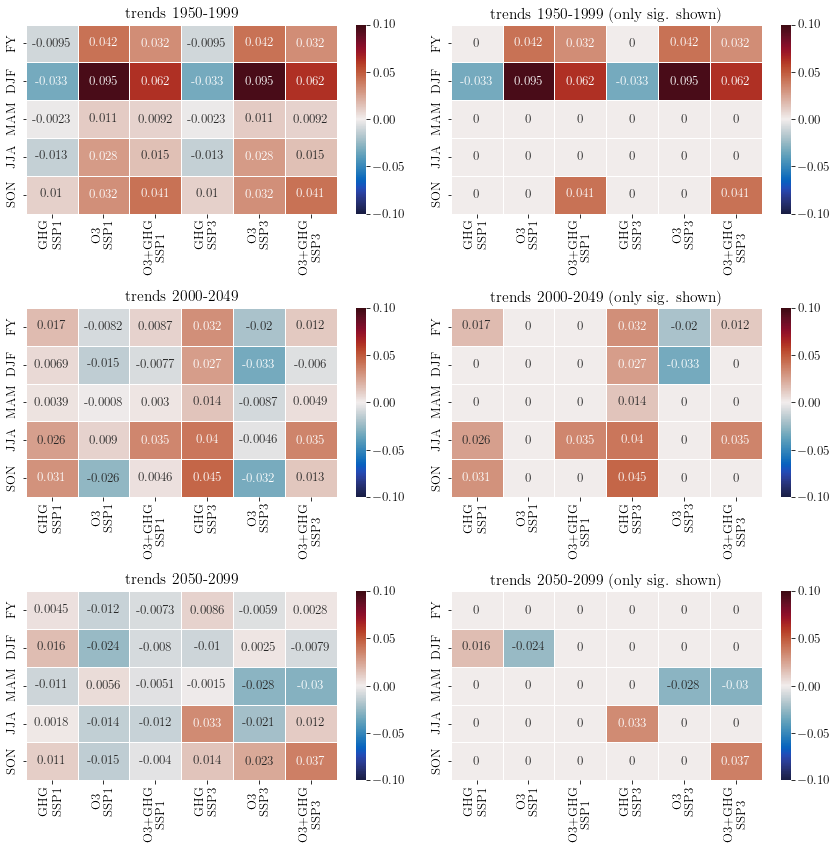

In [11]:

import seaborn as sns
fact = 1
fig, axs = plt.subplots(3,2, figsize=(12*fact, 12*fact), sharex=False, sharey=False)
axs = axs.ravel()

tid = 'trend'
vmin = -0.1; vmax = 0.1; tcmap = cm.balance

y1 = 1950; y2 = 1999; latdeg = '40-60S'; ind = 0
df = pd.read_csv(f'./plts/attr-UKESM3M_{latdeg}-trend-{y1}-{y2}.csv', index_col=0)
df = df.rename(columns={"d2A": "GHG\n SSP1", "dO3A": "O3 \n SSP1", "d1A": "O3+GHG \n SSP1",\
                       "d2B": "GHG\n SSP3", "dO3B": "O3 \n SSP3", "d1B": "O3+GHG \n SSP3"})

sns.heatmap(df, cmap=tcmap, linewidths=0.5, annot=True, vmin = vmin, vmax = vmax, ax = axs[ind])
axs[ind].set_title(f'trends {y1}-{y2}')

df = pd.read_csv(f'./plts/attr-UKESM3M_{latdeg}-trendsig-{y1}-{y2}.csv', index_col=0)
df = df.rename(columns={"d2A": "GHG\n SSP1", "dO3A": "O3 \n SSP1", "d1A": "O3+GHG \n SSP1",\
                       "d2B": "GHG\n SSP3", "dO3B": "O3 \n SSP3", "d1B": "O3+GHG \n SSP3"})

sns.heatmap(df, cmap=tcmap, linewidths=0.5, annot=True, vmin = vmin, vmax = vmax, ax = axs[ind+1])
axs[ind+1].set_title(f'trends {y1}-{y2} (only sig. shown)')

y1 = 2000; y2 = 2049; latdeg = '40-60S'; ind = 2
df = pd.read_csv(f'./plts/attr-UKESM3M_{latdeg}-trend-{y1}-{y2}.csv', index_col=0)
df = df.rename(columns={"d2A": "GHG\n SSP1", "dO3A": "O3 \n SSP1", "d1A": "O3+GHG \n SSP1",\
                       "d2B": "GHG\n SSP3", "dO3B": "O3 \n SSP3", "d1B": "O3+GHG \n SSP3"})

sns.heatmap(df, cmap=tcmap, linewidths=0.5, annot=True, vmin = vmin, vmax = vmax, ax = axs[ind])
axs[ind].set_title(f'trends {y1}-{y2}')

df = pd.read_csv(f'./plts/attr-UKESM3M_{latdeg}-trendsig-{y1}-{y2}.csv', index_col=0)
df = df.rename(columns={"d2A": "GHG\n SSP1", "dO3A": "O3 \n SSP1", "d1A": "O3+GHG \n SSP1",\
                       "d2B": "GHG\n SSP3", "dO3B": "O3 \n SSP3", "d1B": "O3+GHG \n SSP3"})

sns.heatmap(df, cmap=tcmap, linewidths=0.5, annot=True, vmin = vmin, vmax = vmax, ax = axs[ind+1])
axs[ind+1].set_title(f'trends {y1}-{y2} (only sig. shown)')


y1 = 2050; y2 = 2099; latdeg = '40-60S'; ind = 4
df = pd.read_csv(f'./plts/attr-UKESM3M_{latdeg}-trend-{y1}-{y2}.csv', index_col=0)
df = df.rename(columns={"d2A": "GHG\n SSP1", "dO3A": "O3 \n SSP1", "d1A": "O3+GHG \n SSP1",\
                       "d2B": "GHG\n SSP3", "dO3B": "O3 \n SSP3", "d1B": "O3+GHG \n SSP3"})

sns.heatmap(df, cmap=tcmap, linewidths=0.5, annot=True, vmin = vmin, vmax = vmax, ax = axs[ind])
axs[ind].set_title(f'trends {y1}-{y2}')

df = pd.read_csv(f'./plts/attr-UKESM3M_{latdeg}-trendsig-{y1}-{y2}.csv', index_col=0)
df = df.rename(columns={"d2A": "GHG\n SSP1", "dO3A": "O3 \n SSP1", "d1A": "O3+GHG \n SSP1",\
                       "d2B": "GHG\n SSP3", "dO3B": "O3 \n SSP3", "d1B": "O3+GHG \n SSP3"})

sns.heatmap(df, cmap=tcmap, linewidths=0.5, annot=True, vmin = vmin, vmax = vmax, ax = axs[ind+1])
axs[ind+1].set_title(f'trends {y1}-{y2} (only sig. shown)')

plt.tight_layout()

fig.savefig('./plts/trends_1950-2099-heatmap.png')

In [12]:
latdeg = '40-60S'; y1 = 1950; y2 = 1999; seas = 'FY'; scen = 'SSP1'; d = 0; tlw = 2; 

def makebars(y1,y2,seas,scen,d,tlw = 2, latdeg = '40-60S'):
    df = pd.read_csv(f'./plts/attr-UKESM3M_{latdeg}-trend-{y1}-{y2}.csv', index_col=0)
    df2 = pd.read_csv(f'./plts/attr-UKESM3M_{latdeg}-trendsig-{y1}-{y2}.csv', index_col=0)

    #darkgray, black, mediumaquamarine, forestgreen
    s1 = ['d2A','dO3A','d1A']
    s2 = ['d2B','dO3B','d1B',]
    if scen == 'SSP1': s = s1; ghgcol = 'mediumaquamarine'; o3col = 'skyblue'; totcol = 'darkgray'
    else: s = s2; ghgcol = 'forestgreen'; o3col = 'royalblue'; totcol = 'black'

    w = df.loc[seas, s[0]]; w2 = df2.loc[seas, s[0]]
    lw = 0
    if w2 != 0: lw = tlw
    axs[d].bar(1, w, width = 0.8, color = ghgcol, lw = lw, edgecolor = 'r')

    w = df.loc[seas, s[1]]; w2 = df2.loc[seas, s[1]]
    lw = 0
    if w2 != 0: lw = tlw
    axs[d].bar(2, w, width = 0.8, color = o3col, lw = lw, edgecolor = 'r')

    w = df.loc[seas, s[2]]; w2 = df2.loc[seas, s[2]]
    lw = 0
    if w2 != 0: lw = tlw
    axs[d].bar(3, w, width = 0.8, color = totcol, lw = lw, edgecolor = 'r')
    tit = f'{scen} {y1}-{y2} ({seas})'
    axs[d].set_title(tit)
    axs[d].set_xticks([1,2,3])
    axs[d].set_xticklabels(['GHG','O3','GHG+\nO3'])
    axs[d].axhline(y=0)
    
    



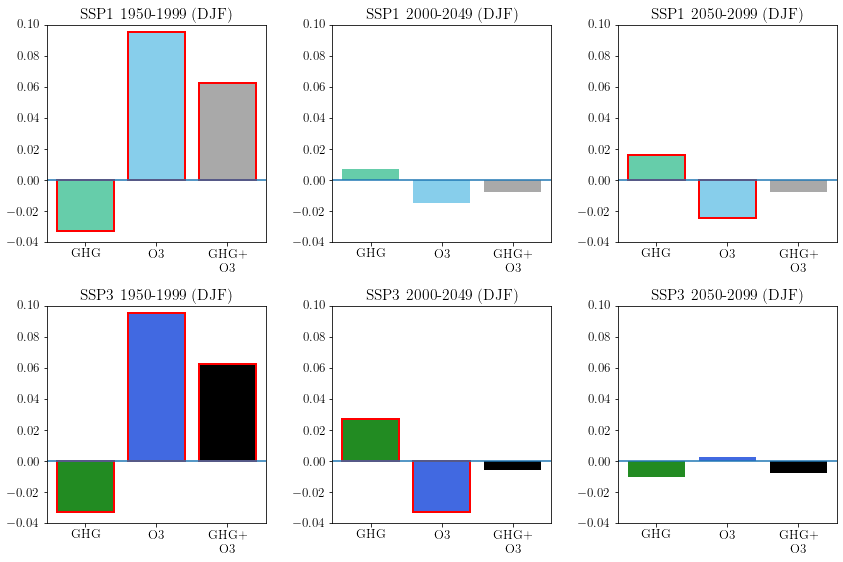

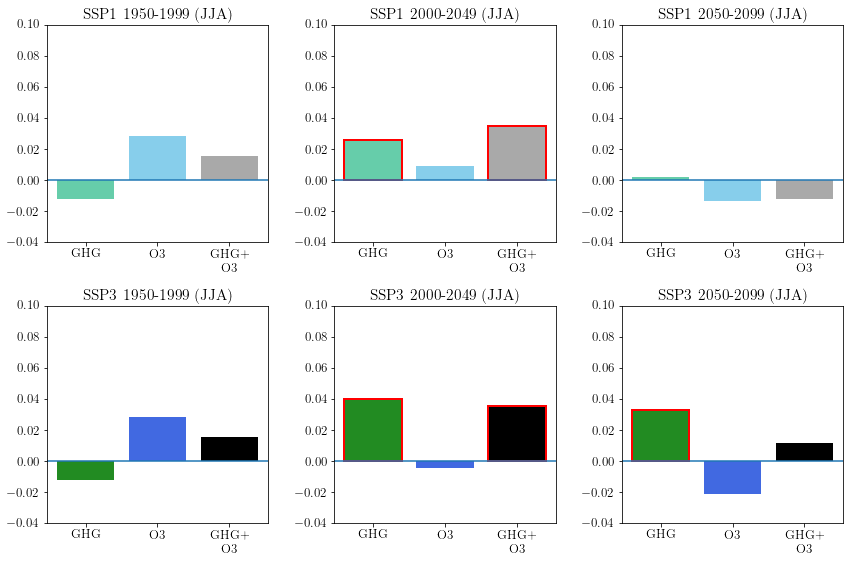

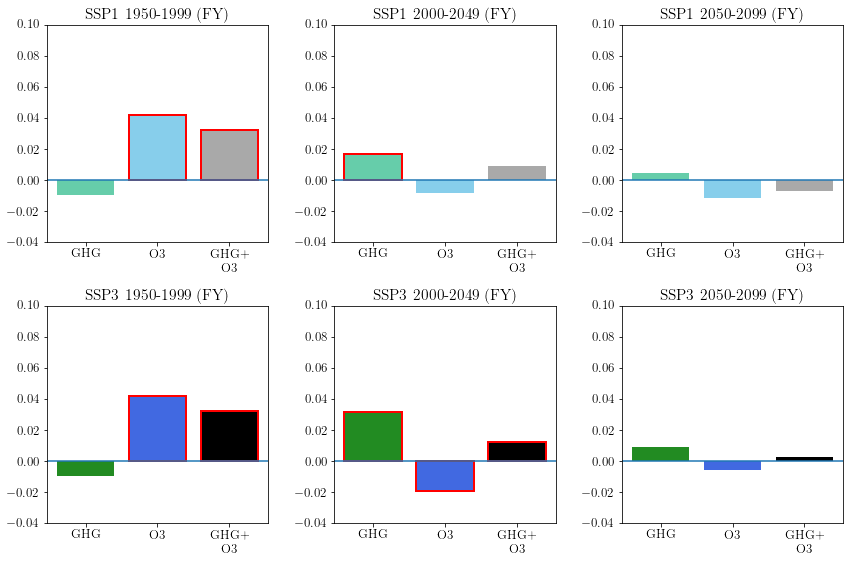

In [13]:
latdeg = '40-60S';

fig, axs = plt.subplots(2,3, figsize=(12*fact, 8*fact), sharex=False, sharey=False)
axs = axs.ravel()
seas = 'DJF'; 


scen = 'SSP1';
y1 = 1950; y2 = 1999;  d = 0;      
makebars(1950,1999,seas,scen,0)
makebars(2000,2049,seas,scen,1)
makebars(2050,2099,seas,scen,2)
scen = 'SSP3';
makebars(1950,1999,seas,scen,3)
makebars(2000,2049,seas,scen,4)
makebars(2050,2099,seas,scen,5)

plt.tight_layout()
ymi = -0.04; yma = 0.1
for i in range(0,6):
    axs[i].set_ylim([ymi, yma])
    
fig.savefig(f'./plts/attr-{seas}-{latdeg}-1950-2100.png')

fig, axs = plt.subplots(2,3, figsize=(12*fact, 8*fact), sharex=False, sharey=False)
axs = axs.ravel()
seas = 'JJA'; 
latdeg = '40-60S';

scen = 'SSP1';
y1 = 1950; y2 = 1999;  d = 0;      
makebars(1950,1999,seas,scen,0)
makebars(2000,2049,seas,scen,1)
makebars(2050,2099,seas,scen,2)
scen = 'SSP3';
makebars(1950,1999,seas,scen,3)
makebars(2000,2049,seas,scen,4)
makebars(2050,2099,seas,scen,5)

plt.tight_layout()
ymi = -0.04; yma = 0.1
for i in range(0,6):
    axs[i].set_ylim([ymi, yma])
    
fig.savefig(f'./plts/attr-{seas}-{latdeg}-1950-2100.png')

fig, axs = plt.subplots(2,3, figsize=(12*fact, 8*fact), sharex=False, sharey=False)
axs = axs.ravel()
seas = 'FY'; 
latdeg = '40-60S';

scen = 'SSP1';
y1 = 1950; y2 = 1999;  d = 0;      
makebars(1950,1999,seas,scen,0)
makebars(2000,2049,seas,scen,1)
makebars(2050,2099,seas,scen,2)
scen = 'SSP3';
makebars(1950,1999,seas,scen,3)
makebars(2000,2049,seas,scen,4)
makebars(2050,2099,seas,scen,5)

plt.tight_layout()
ymi = -0.04; yma = 0.1
for i in range(0,6):
    axs[i].set_ylim([ymi, yma])
    
fig.savefig(f'./plts/attr-{seas}-{latdeg}-1950-2100.png')

In [14]:
latdeg = '40-60S'; y1 = 1950; y2 = 1999; seas = 'FY'; scen = 'SSP1'; d = 0; tlw = 2; 

def makebars(y1,y2,seas,scen,d,tlw = 2, latdeg = '40-60S'):
    df = pd.read_csv(f'./plts/attr-UKESM3M_{latdeg}-trend-{y1}-{y2}.csv', index_col=0)
    df2 = pd.read_csv(f'./plts/attr-UKESM3M_{latdeg}-trendsig-{y1}-{y2}.csv', index_col=0)

    #darkgray, black, mediumaquamarine, forestgreen
    s1 = ['d2A','dO3A','d1A']
    s2 = ['d2B','dO3B','d1B',]
    if scen == 'SSP1': s = s1; ghgcol = 'mediumaquamarine'; o3col = 'skyblue'; totcol = 'darkgray'
    else: s = s2; ghgcol = 'forestgreen'; o3col = 'royalblue'; totcol = 'black'

    w = df.loc[seas, s[0]]; w2 = df2.loc[seas, s[0]]
    lw = 0
    if w2 != 0: lw = tlw
    axs[d].bar(1, w, width = 0.8, color = ghgcol, lw = lw, edgecolor = 'r')

    w = df.loc[seas, s[1]]; w2 = df2.loc[seas, s[1]]
    lw = 0
    if w2 != 0: lw = tlw
    axs[d].bar(2, w, width = 0.8, color = o3col, lw = lw, edgecolor = 'r')

    # w = df.loc[seas, s[2]]; w2 = df2.loc[seas, s[2]]
    # lw = 0
    # if w2 != 0: lw = tlw
    # axs[d].bar(3, w, width = 0.8, color = totcol, lw = lw, edgecolor = 'r')
    
    tit = f'{scen} {y1}-{y2} ({seas})'
    axs[d].set_title(tit)
    axs[d].set_xticks([1,2])
    axs[d].set_xticklabels(['GHG','O3'])
    axs[d].axhline(y=0)
    
    



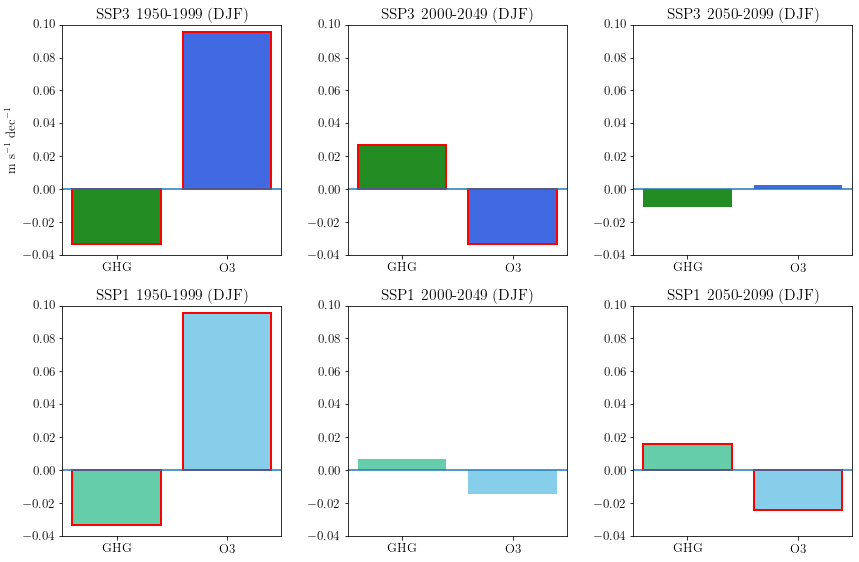

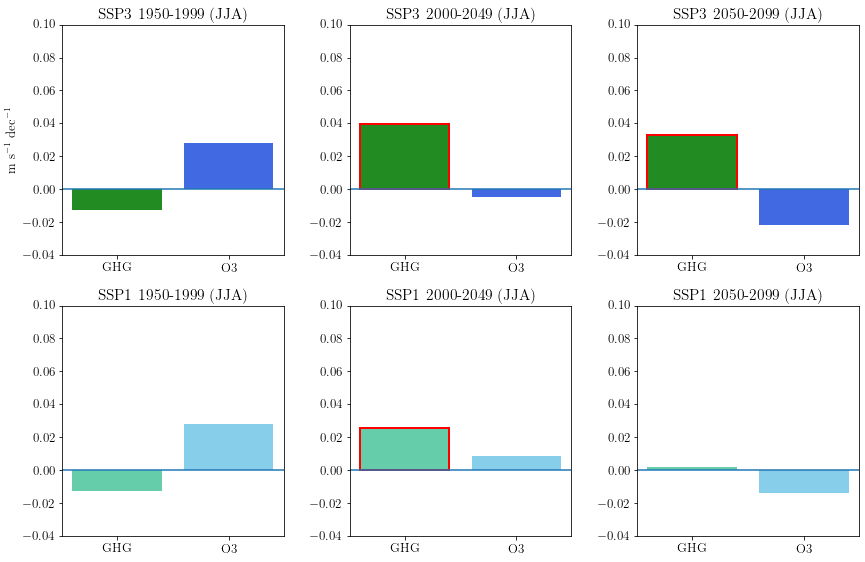

In [15]:
latdeg = '40-60S';

fig, axs = plt.subplots(2,3, figsize=(12*fact, 8*fact), sharex=False, sharey=False)
axs = axs.ravel()
seas = 'DJF'; 


scen = 'SSP1';
y1 = 1950; y2 = 1999;  d = 0;      
makebars(1950,1999,seas,scen,3)
makebars(2000,2049,seas,scen,4)
makebars(2050,2099,seas,scen,5)
scen = 'SSP3';
makebars(1950,1999,seas,scen,0)
makebars(2000,2049,seas,scen,1)
makebars(2050,2099,seas,scen,2)

plt.tight_layout()
ymi = -0.04; yma = 0.1
for i in range(0,6):
    axs[i].set_ylim([ymi, yma])
    
axs[0].set_ylabel('m s$^{-1}$ dec$^{-1}$')
    
fig.savefig(f'./plts/attr-{seas}-{latdeg}-1950-2100.png')

fig, axs = plt.subplots(2,3, figsize=(12*fact, 8*fact), sharex=False, sharey=False)
axs = axs.ravel()
seas = 'JJA'; 
latdeg = '40-60S';

scen = 'SSP1';
y1 = 1950; y2 = 1999;  d = 0;      
makebars(1950,1999,seas,scen,3)
makebars(2000,2049,seas,scen,4)
makebars(2050,2099,seas,scen,5)
scen = 'SSP3';
makebars(1950,1999,seas,scen,0)
makebars(2000,2049,seas,scen,1)
makebars(2050,2099,seas,scen,2)

plt.tight_layout()
ymi = -0.04; yma = 0.1
for i in range(0,6):
    axs[i].set_ylim([ymi, yma])
    
axs[0].set_ylabel('m s$^{-1}$ dec$^{-1}$')
    
fig.savefig(f'./plts/attr-{seas}-{latdeg}-1950-2100.png')


In [16]:
latdeg = '40-60S'; y1 = 1950; y2 = 1999; seas = 'FY'; scen = 'SSP1'; d = 0; tlw = 2; 

def barso3(y1,y2,seas,scen,d,tlw = 2, latdeg = '40-60S', forc = 'ozone'):
    df = pd.read_csv(f'./plts/attr-UKESM3M_{latdeg}-trend-{y1}-{y2}.csv', index_col=0)
    df2 = pd.read_csv(f'./plts/attr-UKESM3M_{latdeg}-trendsig-{y1}-{y2}.csv', index_col=0)

    #darkgray, black, mediumaquamarine, forestgreen
    s1 = ['d2A','dO3A','d1A']
    s2 = ['d2B','dO3B','d1B',]
    
    if forc == 'ozone': ind =0 
    else: ind = 1
        
    if scen == 'SSP1': s = s1; o3col = 'skyblue'; totcol = 'darkgray'
    else: s = s2; ghgcol = 'forestgreen'; o3col = 'royalblue'; totcol = 'black'

    w = df.loc['FY', s[ind]]; w2 = df2.loc[seas, s[ind]]
    lw = 0
    if w2 != 0: lw = tlw
    axs[d].bar(1, w, width = 0.8, color = ghgcol, lw = lw, edgecolor = 'r')

    w = df.loc['DJF', s[ind]]; w2 = df2.loc[seas, s[ind]]
    lw = 0
    if w2 != 0: lw = tlw
    axs[d].bar(2, w, width = 0.8, color = o3col, lw = lw, edgecolor = 'r')

    # w = df.loc[seas, s[2]]; w2 = df2.loc[seas, s[2]]
    # lw = 0
    # if w2 != 0: lw = tlw
    # axs[d].bar(3, w, width = 0.8, color = totcol, lw = lw, edgecolor = 'r')
    
    tit = f'{scen} {y1}-{y2} ({seas})'
    axs[d].set_title(tit)
    axs[d].set_xticks([1,2])
    axs[d].set_xticklabels(['GHG','O3'])
    axs[d].axhline(y=0)
    
    

